<a href="https://colab.research.google.com/github/mariyakj/ASD/blob/main/ann_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive if your data is stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Mount Google Drive if your data is stored there
from google.colab import drive
drive.mount('/content/drive')

# Define paths to your training and validation datasets
train_data_dir = '/content/drive/MyDrive/autism mri/Training'
val_data_dir = '/content/drive/MyDrive/autism mri/Testing'

# Parameters
img_width, img_height = 150, 150
batch_size = 32
epochs = 50 # Increase the number of epochs

# Data Augmentation
train_datagen = ImageDataGenerator(
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary'
)

# Load and preprocess validation data
val_generator = val_datagen.flow_from_directory(
val_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary'
)

# ANN Model
ann_model = Sequential()

# Flatten layer
ann_model.add(Flatten(input_shape=(img_width, img_height, 3)))

# Dense layers
ann_model.add(Dense(256, activation='relu'))
ann_model.add(Dropout(0.5)) # Dropout for regularization
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

# Compile the model
ann_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
ann_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the ANN model
history = ann_model.fit(train_generator,
steps_per_epoch=len(train_generator),
epochs=epochs,
validation_data=val_generator,
validation_steps=len(val_generator),
callbacks=[early_stopping, reduce_lr])

# Save the trained model to an HDF5 file
ann_model.save('/content/drive/MyDrive/models/ann_mri_model_improved.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3167 images belonging to 2 classes.
Found 760 images belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 256)               17280256  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17321473 (66.08 MB)
Trainable params: 1732

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Mount Google Drive if your model is stored there
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your saved model
saved_model_path = '/content/drive/MyDrive/models/ann_mri_model_improved.h5'

# Load the model
loaded_model = tf.keras.models.load_model(saved_model_path)

# Define the path to the image you want to predict
image_path = '/content/drive/MyDrive/autism mri/Testing/autistic/Te-pi_0278.jpg'

# Load and preprocess the image
img = image.load_img(image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the pixel values

# Make the prediction
prediction = loaded_model.predict(img_array)
print(prediction[0][0]);
# Interpret the prediction
if prediction[0][0] < 0.5:
    print("Prediction: Class 1 (Autistic)")
else:
    print("Prediction: Class 0 (Non-autistic)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 59ms/step
0.18632783
Prediction: Class 1 (Autistic)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Load the validation data
val_data_dir = '/content/drive/MyDrive/autism mri/Testing'
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(150, 150),
    batch_size=1,  # Set batch size to 1 to ensure we get predictions for each sample
    class_mode='binary',
    shuffle=False  # Ensure that predictions match labels
)

# Make predictions for the validation set
predictions = loaded_model.predict(val_generator)

# Convert probabilities to class labels
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Get true labels
true_classes = val_generator.classes

# Calculate metrics
accuracy = np.mean(predicted_classes == true_classes)
report = classification_report(true_classes, predicted_classes)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print metrics
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)


Found 760 images belonging to 2 classes.
760/760 [==============================] - 13s 16ms/step
Accuracy: 0.5066481994459834

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       320
           1       1.00      0.94      0.97       440

    accuracy                           0.96       760
   macro avg       0.96      0.97      0.96       760
weighted avg       0.97      0.96      0.96       760


Confusion Matrix:
[[320   0]
 [ 28 412]]


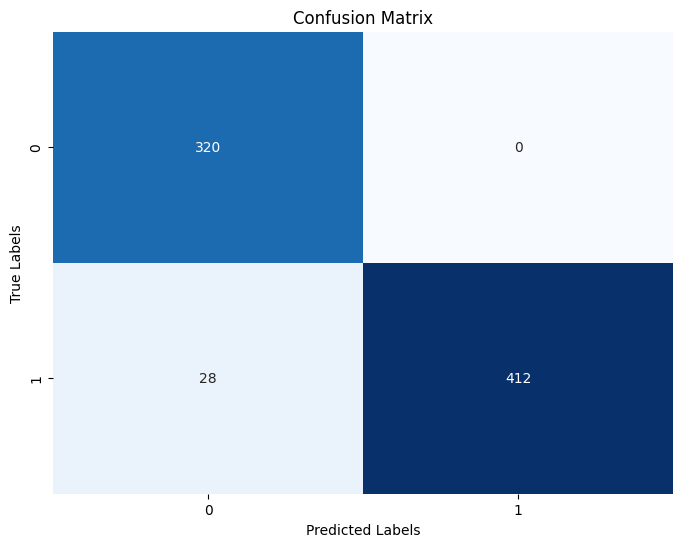

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
